https://www.kaggle.com/code/ohseokkim/predicting-future-by-lstm-prophet-neural-prophet/notebook

In [33]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [34]:
import neuralprophet

In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch

In [36]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

데이터 불러오기

In [37]:
flight_data = pd.read_csv('C:\\data\\AirPassengers.csv')


In [38]:
flight_data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [39]:
flight_data[['year', 'month']] = flight_data['Month'].str.split('-', expand=True)
flight_data.drop('Month', axis=1, inplace=True)
flight_data.head()

,#Passengers,year,month
0,112,1949,01
1,118,1949,02
2,132,1949,03
3,129,1949,04
4,121,1949,05


In [40]:
flight_data.rename(columns={"#Passengers":"passengers"}, inplace=True)
flight_data

,passengers,year,month
0,112,1949,01
1,118,1949,02
2,132,1949,03
3,129,1949,04
4,121,1949,05
...,...,...,...
139,606,1960,08
140,508,1960,09
141,461,1960,10
142,390,1960,11


In [41]:
flight_data = flight_data[['year', 'month', 'passengers']]
print(flight_data)

     year month  passengers
0    1949    01         112
1    1949    02         118
2    1949    03         132
3    1949    04         129
4    1949    05         121
..    ...   ...         ...
139  1960    08         606
140  1960    09         508
141  1960    10         461
142  1960    11         390
143  1960    12         432

[144 rows x 3 columns]


In [42]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        144 non-null    object
 1   month       144 non-null    object
 2   passengers  144 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.5+ KB


In [43]:
flight_data[['year', 'month']] = flight_data[['year', 'month']].apply(lambda x:x.astype(int))
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        144 non-null    int32
 1   month       144 non-null    int32
 2   passengers  144 non-null    int64
dtypes: int32(2), int64(1)
memory usage: 2.4 KB


In [44]:
print(flight_data.describe())
print('-'*40)
print(flight_data.tail())

              year       month  passengers
count   144.000000  144.000000  144.000000
mean   1954.500000    6.500000  280.298611
std       3.464102    3.464102  119.966317
min    1949.000000    1.000000  104.000000
25%    1951.750000    3.750000  180.000000
50%    1954.500000    6.500000  265.500000
75%    1957.250000    9.250000  360.500000
max    1960.000000   12.000000  622.000000
----------------------------------------
     year  month  passengers
139  1960      8         606
140  1960      9         508
141  1960     10         461
142  1960     11         390
143  1960     12         432


In [45]:
flight_data.shape

(144, 3)

In [46]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        144 non-null    int32
 1   month       144 non-null    int32
 2   passengers  144 non-null    int64
dtypes: int32(2), int64(1)
memory usage: 2.4 KB


시각화

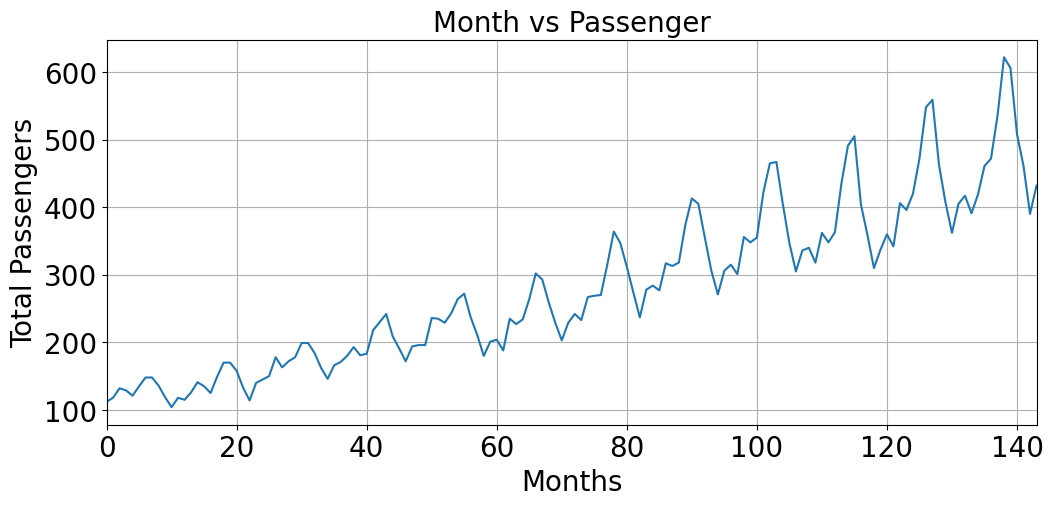

In [47]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger', fontsize=20)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Total Passengers', fontsize=20)
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['passengers'])

요소분해(seasonal_decomposition)

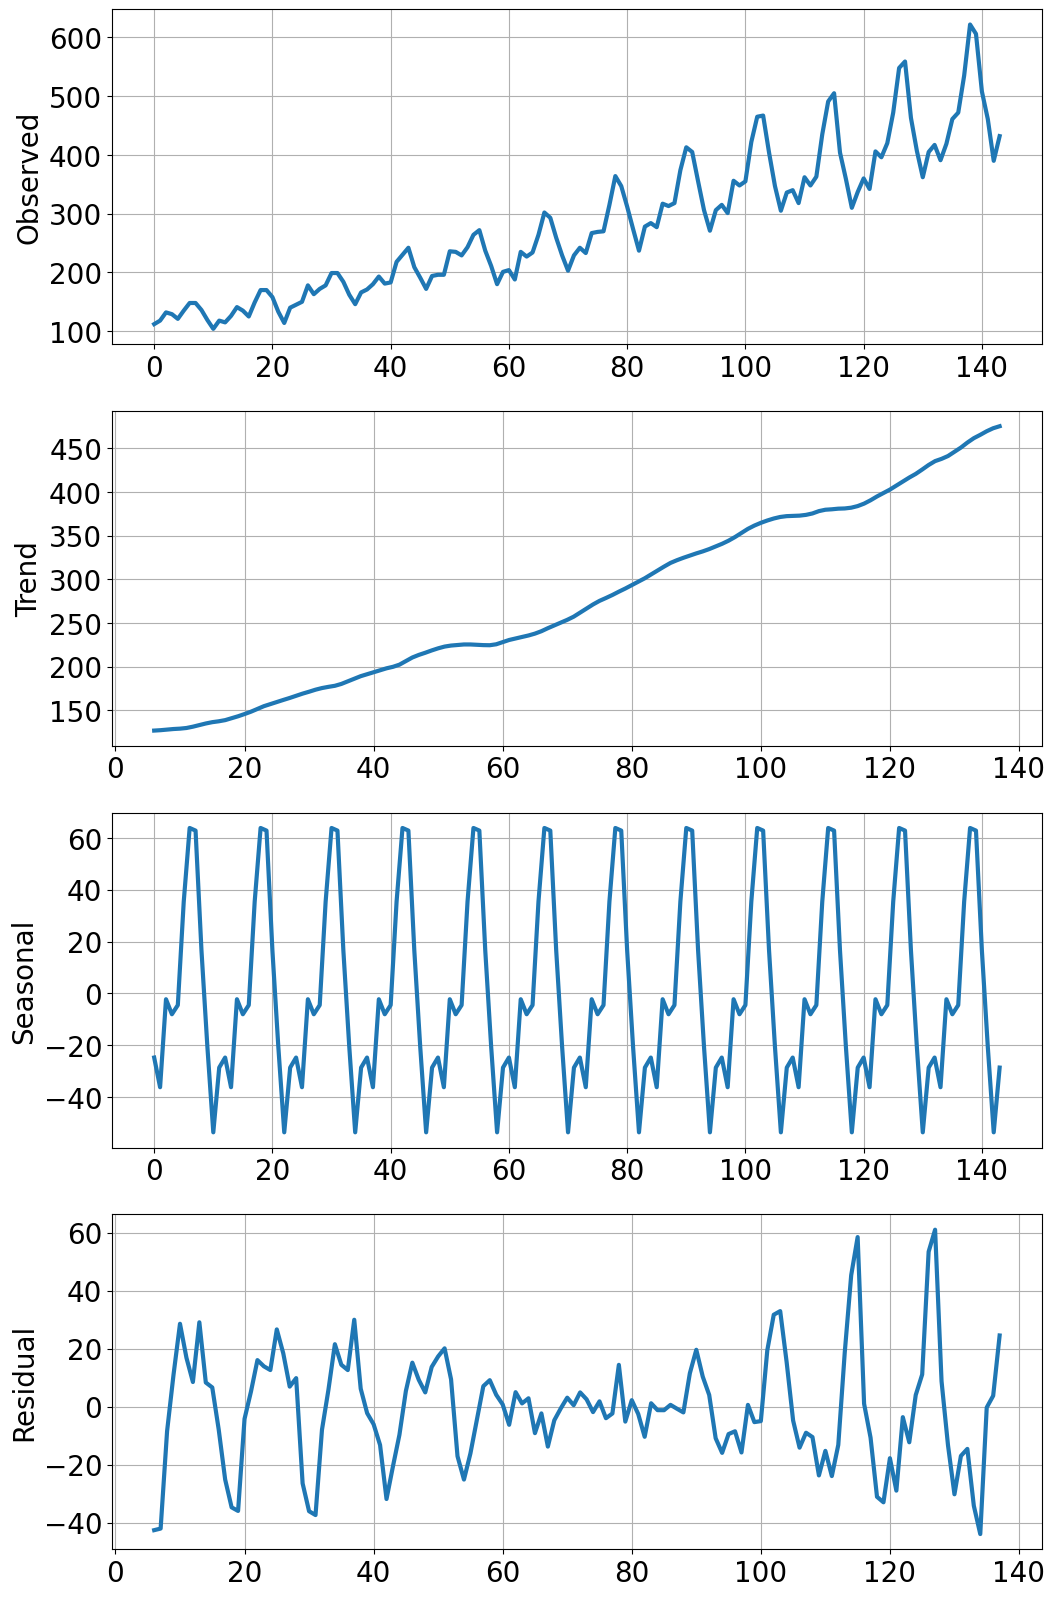

In [48]:
import statsmodels
import statsmodels.api as sm 
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(flight_data['passengers'], period=12)
plot_decompose(decomposition)

데이터 전처리

In [51]:
all_data = flight_data['passengers'].values.astype(float)
print(all_data)
print(all_data.shape)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]
(144,)


In [52]:
test_data_size = 12
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [53]:
print(len(train_data))
print(len(test_data))

132
12


In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))

In [56]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

start from utility function 